In [64]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import json

In [2]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


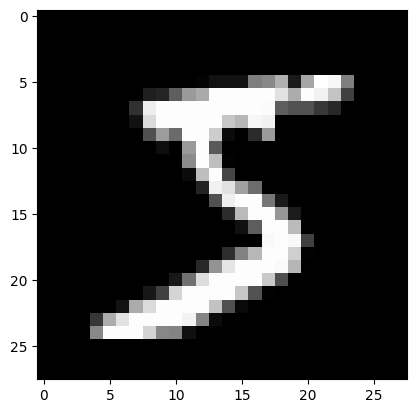

In [3]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_test)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
# Input image
input_img = Input(shape=(784,))

In [8]:
# encoder
encoded = Dense(256, activation='relu')(input_img)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [9]:
# decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [10]:
autoencoder = Model(input_img, decoded)

In [11]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True,
                          validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/100
938/938 [==============================] - 6s 5ms/step - loss: 0.0644 - val_loss: 0.0543
Epoch 2/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0539 - val_loss: 0.0476
Epoch 3/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0506 - val_loss: 0.0444
Epoch 4/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0488 - val_loss: 0.0432
Epoch 5/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0476 - val_loss: 0.0422
Epoch 6/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0470 - val_loss: 0.0413
Epoch 7/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0464 - val_loss: 0.0408
Epoch 8/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0461 - val_loss: 0.0406
Epoch 9/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0459 - val_loss: 0.0406
Epoch 10/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0456 - val_lo

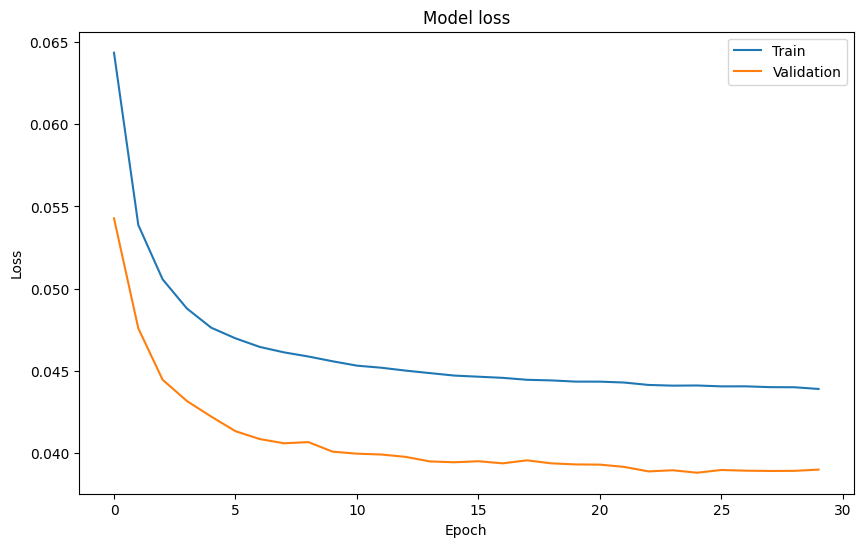

In [13]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 1ms/step


In [15]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [16]:
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [51]:
# Classify anomalies based on the threshold
predictions = (reconstruction_errors > threshold).astype(int)

In [17]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [y_test[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [   8   18   54   77  119  149  200  222  225  245  287  311  338  362
  421  437  445  461  486  492  514  553  611  612  617  625  646  654
  655  684  691  710  711  720  738  787  792  810  844  864  876  877
  894  896  923  924  985  998 1017 1031 1050 1052 1060 1073 1101 1102
 1119 1128 1143 1170 1187 1251 1253 1263 1272 1325 1337 1345 1352 1377
 1395 1421 1425 1444 1463 1468 1526 1530 1556 1567 1574 1601 1610 1618
 1627 1641 1712 1720 1722 1737 1748 1749 1758 1782 1790 1801 1813 1859
 1895 1984 2040 2044 2057 2058 2060 2107 2110 2115 2118 2129 2145 2159
 2170 2186 2215 2224 2229 2237 2253 2266 2272 2291 2293 2299 2326 2328
 2337 2351 2436 2462 2470 2479 2515 2517 2542 2589 2609 2635 2649 2653
 2664 2684 2697 2728 2747 2770 2773 2790 2797 2802 2830 2927 2959 2990
 3011 3016 3037 3073 3120 3181 3198 3242 3260 3269 3284 3288 3289 3290
 3295 3311 3347 3348 3364 3384 3394 3401 3412 3441 3517 3521 3525 3534
 3542 3681 3705 3710 3727 3768 3778 3799 3813 3817 3818 3829

In [18]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

print(len(anomalies))

500


In [19]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [y_test[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [20]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [21]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


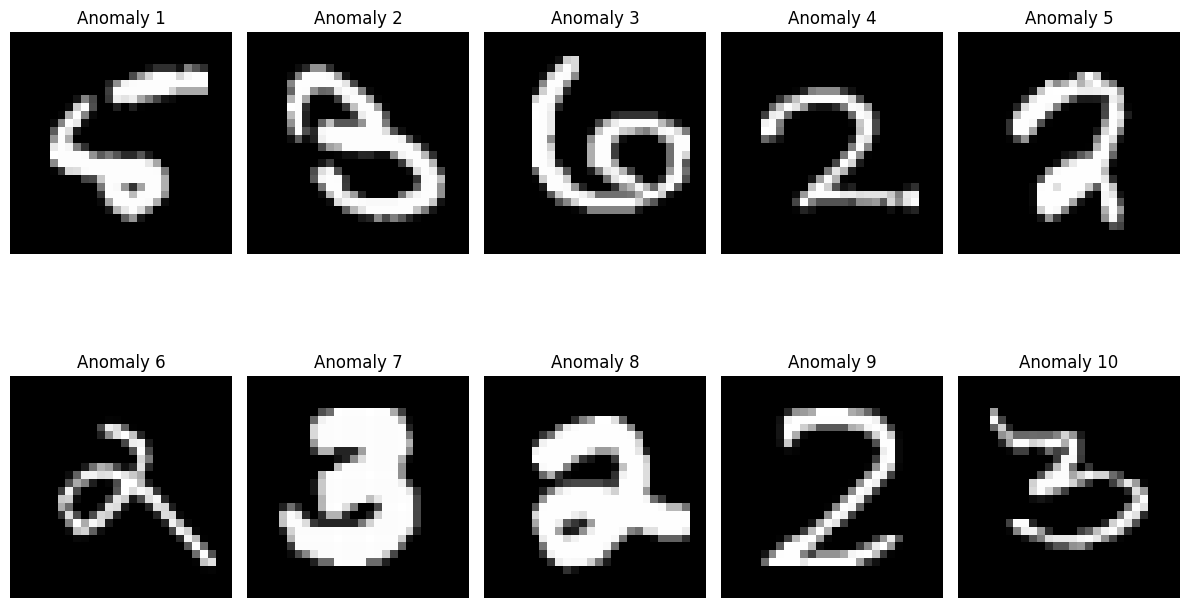

In [22]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


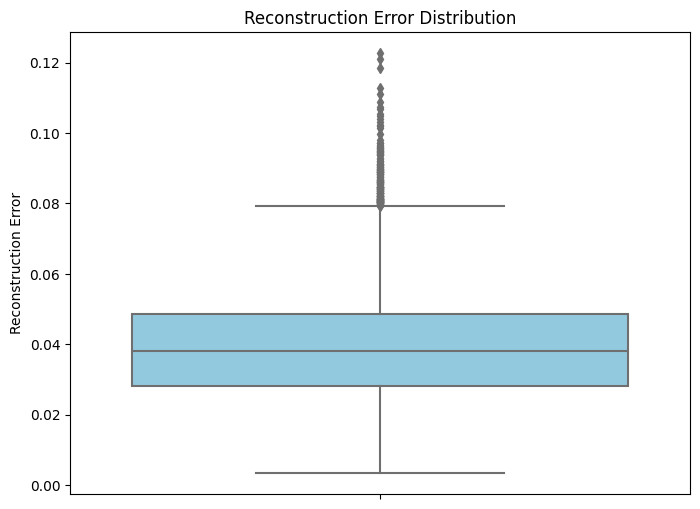

In [34]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

In [57]:
# Map the class labels to "anomaly" and "normal"
class_labels = {0: 'normal', 1: 'anomaly'}
predictions_mapped = np.vectorize(class_labels.get)(predictions)
y_test_mapped = np.vectorize(class_labels.get)(y_test)

In [59]:
# Ensure that y_test_mapped and predictions_mapped are binary (0 or 1)
y_test_mapped_binary = np.where(y_test_mapped == 'anomaly', 1, 0)
predictions_mapped_binary = np.where(predictions_mapped == 'anomaly', 1, 0)

In [65]:
# Evaluate performance metrics
accuracy = accuracy_score(y_test_mapped_binary, predictions_mapped_binary)
precision = precision_score(y_test_mapped_binary, predictions_mapped_binary)
recall = recall_score(y_test_mapped_binary, predictions_mapped_binary)
f1 = f1_score(y_test_mapped_binary, predictions_mapped_binary)

In [66]:
# Print and display the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8369
Precision: 0.004
Recall: 0.001762114537444934
F1 Score: 0.0024464831804281344


In [67]:
report = classification_report(y_test_mapped_binary, predictions_mapped_binary, target_names=['normal', 'anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.94      0.91      8865
     anomaly       0.00      0.00      0.00      1135

    accuracy                           0.84     10000
   macro avg       0.44      0.47      0.46     10000
weighted avg       0.78      0.84      0.81     10000



In [70]:
# calculate the precision and recall for different threshold levels
precision_curve, recall_curve, _ = precision_recall_curve(y_test_mapped_binary, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall_curve, precision_curve)

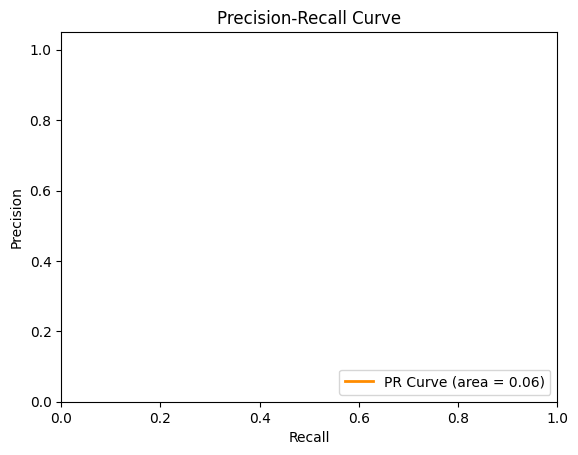

In [71]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [75]:
conf_matrix = confusion_matrix(y_test_mapped_binary, predictions_mapped_binary)

In [76]:
print(conf_matrix)

[[8367  498]
 [1133    2]]


In [77]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 8367
False Positives: 498
False Negatives: 1133
True Positives: 2
